In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
# Pkg.add("ForwardDiff")
# Pkg.add("RobotDynamics")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
# Pkg.add("SparseArrays")
# Pkg.add("Plots")
# Pkg.add("Printf")
# Pkg.add("Ipopt")
# Pkg.add("MathOptInterface")
# Pkg.add("TrajOptPlots")
# Pkg.add("JLD")
# Pkg.add("Symbolics")
Pkg.add("Rotations")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Ipopt
using MathOptInterface
using TrajOptPlots
using JLD
using Symbolics
const MOI = MathOptInterface
using Rotations
# Pkg.add("Multi-Threading")
# using Multi-Threading
# using PyPlots
using Printf

# include("quadratic_cost.jl")


# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

### Problem Setup

In [3]:
# Problem Setup

Nx = 6 # (x, y, z, ẋ, ẏ, ż)
Nu = 4 # (ax, ay, az, h)


#cartesian and ECI

earthRadius_km = 6378.1 # [km]
LEO_km = 500 #km above sealevel #circular low earth orbit # 250km 
GSO_km = 35786 #km above sealevel #circular geosychonous orbit
μ_km_s = 3.986*10e5 #gravitational0 parameter [km^3 / s^2]
semiMajorAxis_scale = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/2
period_scale = sqrt(semiMajorAxis_scale^3/μ_km_s)*2*pi
μ = μ_km_s*period_scale^2/semiMajorAxis_scale^3  #μ(OU^3/P^2)

struct Orbit{T}
    semiMajorAxis::T
    period::T
    perigee::T #closest radius to earth
    perigee_V::T #velocity at perigee
    x0::Vector{T}
#     function Orbit(x0) 
#         print(x0) #best is to input point with velocity and calucate useful parts of orbit
#     end
end

function make_orbit(x0)
    velocity = norm(x0[4:end])
    
    radius = norm(x0[1:3])
    
    semiMajorAxis = 1/(-velocity^2/μ+2/radius)  #reverse vis a viv
    
    period = sqrt(semiMajorAxis^3/μ)*2*pi       #period equation
    
    E = velocity^2/2 - μ/radius   #specific energy of satellite
    
    J = norm(cross(x0[1:3],x0[4:end]))           #specific momentum of satellite
    
    perigee = -μ/(2*E) - 1/2*sqrt(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    
    perigee_v =  sqrt(μ*(2.0/perigee-1.0/semiMajorAxis)) # Vis a Viv
    apogee  = -μ/(2*E) + 1/2(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    apogee_v =  sqrt(μ*(2.0/apogee-1.0/semiMajorAxis)) # Vis a Viv
    return Orbit(semiMajorAxis, period, perigee, perigee_v, x0)
end

make_orbit (generic function with 1 method)

In [4]:
# Geosynchronous Transfer orbit (starting position)
semiMajorAxis_transfer = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/(2*semiMajorAxis_scale) #OU
instantRadius_transfer = (earthRadius_km+LEO_km) / semiMajorAxis_scale # #OU
instantVelocity_transfer = sqrt(μ*(2.0/instantRadius_transfer-1.0/semiMajorAxis_transfer)) #sqrt(OU^3/P^2/OU) =OU/P
period_transfer = sqrt(semiMajorAxis_transfer^3/μ)*2*pi
x0    = [instantRadius_transfer, 0.0, 0.0, 0.0, instantVelocity_transfer, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
transfer_orbit = Orbit(semiMajorAxis_transfer, period_transfer, instantRadius_transfer, instantVelocity_transfer, x0)

Orbit{Float64}(1.0, 1.0, 0.28049720444841386, 15.556684458046954, [0.28049720444841386, 0.0, 0.0, 0.0, 15.556684458046954, 0.0])

In [5]:
# Geosynchronous Orbit (goal position)
semiMajorAxis_goal = 2*(earthRadius_km+GSO_km)/(2*semiMajorAxis_scale)
instantRadius_goal = (earthRadius_km+GSO_km) / semiMajorAxis_scale
instantVelocity_goal = sqrt(μ*(2.0/instantRadius_goal-1.0/semiMajorAxis_goal)) # VisViva
period_goal = sqrt(semiMajorAxis_goal^3/μ)*2*pi
xgoal = [instantRadius_goal, 0.0, 0.0, 0.0, instantVelocity_goal, 0.0] # goal state #circular geosychonous orbit above africa
goal_orbit = Orbit(semiMajorAxis_goal, period_goal, instantRadius_goal, instantVelocity_goal, xgoal)
ugto = zeros(3)                  # hover controls


3-element Vector{Float64}:
 0.0
 0.0
 0.0

## Cost Function

\begin{equation}
    \text{minimize} \sum_{k=1}^{N-1} (||u_k||^2 + (r_k-\bar{r})^2 + \frac{1}{r_k} * h_k) + (r_N-\bar{r})^2+(\dot{r}_N-\bar{\dot{r}})^2 \\
    x_1=x_{init} \\
    r_N = \bar{r} \\
    \dot{r_N} = \bar{\dot{r}} \\
    x_N \cdot \dot{x}_N = 0 \\
    f(x_k, u_k) = x_{k+1} \forall k \\
    0\leq||u_k||\leq T_{max} \forall k \\
    h_{min}\leq h_k \leq h_{max} \forall k
\end{equation}

In [6]:
function cost(prob, Z)
    X, U = unpackZ(prob.N, Z)

    N = prob.N
    J = 0.0
    for k = 1:N-1
        r = norm(X[1:3, k])
        J += norm(U[1:3, k])^2 + (r-goal_orbit.perigee)^2 + 1/r*U[end, k]
    end 
    # Check major and semi-major axis 
    J += ((norm(X[1:3,end])-norm(xgoal[1:3]))^2+(norm(X[4:end,end])-norm(xgoal[4:end]))^2)
    return J 
end

cost (generic function with 1 method)

## Dynamics

In [7]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz, h]
    r = x[1:3] #orbital units (OU)
    ṙ = x[4:end] #
    r̈ = (-μ/(norm(r)^3))*r + u[1:3] #μ(OU^3/P^2)/OU^3*OU
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [8]:
function dynamics_rk4!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4! (generic function with 1 method)

In [9]:
function dynamics_rk4(x, u, h) # Maybe rk8 or more
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    return (x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end

dynamics_rk4 (generic function with 1 method)

In [10]:
function dynamics_rk8(x, u, h)
    f1 = dynamics(x, u)
    f2 = dynamics(x+(h*4/27)*f1, u)
    f3 = dynamics(x+ h/18*(f1+3*f2), u)
    f4 = dynamics(x+ h/12*(f1+3*f3), u)
    f5 = dynamics(x+ h/8*(f1+3*f4), u)
    f6 = dynamics(x+ h/54*(12*f1-27*f3+42*f4+8*f5), u)
    f7 = dynamics(x+ (h/4320)*(389*f1-54*f3+966*f4-824*f5+243*f6), u)
    f8 = dynamics(x+  (h/20)*(-234*f1+81*f3-1164*f4+656*f5-122*f6+800*f7), u)
    f9 = dynamics(x+ (h/288)*(-127*f1+18*f3-678*f4+456*f5-9*f6+576*f7+4*f8), u)
    f10 = dynamics(x+ (h/820)*(1481*f1-81*f3+7104*f4-3376*f5+72*f6-5040*f7-60*f8+720*f9), u)
    
    return (x + h/840*(41*f1+27*f4+272*f5+27*f6+216*f7+216*f9+41*f10))

end

dynamics_rk8 (generic function with 1 method)

In [11]:
function dynamics_rk8!(x, u, h)
    f1 = dynamics(x, u)
    f2 = dynamics(x+(h*4/27)*f1, u)
    f3 = dynamics(x+ h/18*(f1+3*f2), u)
    f4 = dynamics(x+ h/12*(f1+3*f3), u)
    f5 = dynamics(x+ h/8*(f1+3*f4), u)
    f6 = dynamics(x+ h/54*(12*f1-27*f3+42*f4+8*f5), u)
    f7 = dynamics(x+ (h/4320)*(389*f1-54*f3+966*f4-824*f5+243*f6), u)
    f8 = dynamics(x+  (h/20)*(-234*f1+81*f3-1164*f4+656*f5-122*f6+800*f7), u)
    f9 = dynamics(x+ (h/288)*(-127*f1+18*f3-678*f4+456*f5-9*f6+576*f7+4*f8), u)
    f10 = dynamics(x+ (h/820)*(1481*f1-81*f3+7104*f4-3376*f5+72*f6-5040*f7-60*f8+720*f9), u)
    
    x .+= (h/840)*(41*f1+27*f4+272*f5+27*f6+216*f7+216*f9+41*f10)
end

dynamics_rk8! (generic function with 1 method)

In [46]:
function plot_orbit(orbit::Orbit, model, knots=100, orbits=1)
    h = orbits/(knots-1)#t[2]-t[1]
    traj = zeros(knots, Nx)
    x = copy(orbit.x0)
    traj[1,:] .= x
    
    u = zeros(3)

    for i in 2:knots
        x = model(x, u, h)
        traj[i,:] .= x
    end
#     plot(t, energy)
    plot(traj[:, 1], traj[:, 2], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5), label="Trajectory: knots=$(knots) orbits=$(orbits)\n")
    xlabel!("Orbital Units")
    ylabel!("Orbital Units")
    Plots.display(title!("$(model) Trajectory"))
    return traj
end

plot_orbit (generic function with 3 methods)

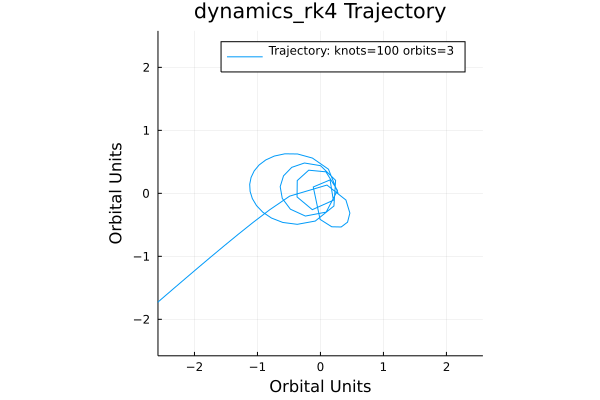

DIFFERENCE: 24.38818135303061


In [48]:
# plot(t, energy)
traj = plot_orbit(transfer_orbit, dynamics_rk4, 100, 3)
println("DIFFERENCE: ", norm(traj[end, :] - traj[1, :]))

# time = 1/ radius 

## Constraints

$ c = [c_{init}, c_{terminal}, c_{dynamics}, c_{thrust}, c_{time}] $

In [49]:
function unpackZ(N, ztraj)
    """
    Inputs: 
        ztraj -> Trajectory
    
    Returns: 
        xtraj -> state trajectory (Nx, T)
        utraj -> control trajectory (Nu, T-1)
    """
    Nt = N
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = hcat(z[1:Nx,:], ztraj[end-(Nx-1):end])
    utraj = z[(Nx+1):(Nx+Nu),:]
    
    return xtraj, utraj
end

unpackZ (generic function with 1 method)

In [50]:
function dynamics_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """

    X, U = unpackZ(nlp.N, ztraj)
    N = nlp.N

    d = reshape(view(c, nlp.idx_ineq[3]), Nx, (N-1))
    
    for k = 1:N-1
        u = U[1:3, k]
        h = U[4, k]
#         d[:, k] .= dynamics_rk8(X[:,k], u, h) - X[:,k+1]
        d[:, k] .= nlp.model(X[:, k], u, h) - X[:, k+1]
    end
    
    return d
end
    

dynamics_constraints! (generic function with 1 method)

In [51]:
function thrust_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    N = nlp.N
    d = view(c, nlp.idx_ineq[4]) 
    X, U = unpackZ(nlp.N, ztraj)
    
    for k = 1:N-1
        d[k] = norm(U[1:3,k])
    end
    
    
    return d
end

thrust_constraints! (generic function with 1 method)

In [52]:
function time_constraints!(nlp, c, ztraj)
    N = nlp.N
    d = view(c, nlp.idx_ineq[5])
    X, U = unpackZ(nlp.N, ztraj)
    
    d[:] .= U[end, :]
    
    return d
    
end

time_constraints! (generic function with 1 method)

In [53]:
function con!(nlp, c, Z)
    X, U = unpackZ(nlp.N, Z)
    c[nlp.idx_ineq[1]] .= X[:,1] - nlp.zref[1:Nx, 1] # Initial condition constraint
    c[nlp.idx_ineq[2][1]] = (norm(X[1:3,end]) - norm(xgoal[1:3]))
    c[nlp.idx_ineq[2][2]] = (norm(X[4:end, end])-norm(xgoal[4:end]))
    c[nlp.idx_ineq[2][3]] = dot(X[1:3, end], X[4:end, end]) # Final condition constraint
    c[nlp.idx_ineq[2][4]] = X[3,end]
    c[nlp.idx_ineq[2][5]] = X[6,end]

    dynamics_constraints!(nlp, c, Z) # Dynamics constraints
    thrust_constraints!(nlp, c, Z) # Thrust constraints
    time_constraints!(nlp, c, Z)
end

con! (generic function with 1 method)

## Constraint Jacobian

In [54]:
function terminal_constraint_jacobian!(nlp, jac, Z)
    X, U = unpackZ(nlp.N, Z)

    term_r = X[1:3, end]./(norm(X[1:3,end])+1e-12) #(3, 1)
    term_v = X[4:6, end]./(norm(X[4:6,end])+1e-12) #(3, 1)

    jac .= [([term_r, term_v, X[4:6, end], X[1:3, end], 1.0, 1.0]...)...]
    
end

terminal_constraint_jacobian! (generic function with 1 method)

In [55]:
function dynamics_wrapper(nlp, zk)
    # zk is the state at time k 
    
    x = zk[1:Nx]
    u = zk[Nx+1:Nx+3]
    h = zk[Nx+4]
    
    out = nlp.model(x, u, h)
    
    return out
end

dynamics_wrapper (generic function with 1 method)

In [56]:
function dynamics_constraint_jacobian!(nlp, jac, Z)
#     D = rehape(view(jac, nlp.cinds[3], :), 
    N = nlp.N
    ix = [Int((Nx+Nu)*i+1):Int((Nx+Nu)*i+Nx) for i=0:N-1]
    iu = [Int((Nx)*i+Nu*(i-1)+1):Int((Nx+Nu)*i) for i=1:N-1]
    
    step = 96
    step2 = 60
    for k =0:N-2
        j1 = view(jac, k*step+1:step*k+step2)
        j2 = view(jac, step*k+step2+1:step*k+step)

        ForwardDiff.jacobian!(j1, z->dynamics_wrapper(nlp, z), Z[ix[k+1][1]:iu[k+1][end]])
        j2 .= [(-1.0*Matrix(I, 6, 6)...)...]

    end
    
    return nothing
end

dynamics_constraint_jacobian! (generic function with 1 method)

In [57]:
function thrust_constraint_jacobian!(nlp, jac, Z)

    X, U = unpackZ(nlp.N, Z)

    norms_grad = [([u./(1e-12+norm(u)) for u in U[1:3,:]]...)...]
    jac .= norms_grad # (3*(N-1))
    return nothing
end

thrust_constraint_jacobian! (generic function with 1 method)

In [58]:
function jac_c!(nlp, jac, Z)
    N = nlp.N
    i_init = 1:Nx
    i_term = i_init[end]+1:i_init[end]+3+3+6+1+1
    
    i_dyn = i_term[end]+1:i_term[end]+(Nx*(Nx+Nu+Nx)*(N-1))
    
    i_thrust = i_dyn[end]+1:i_dyn[end]+3*(N-1)
    
    i_time = i_thrust[end]+1:i_thrust[end]+(N-1) # Definitely not sure about this

    
    jac_init = view(jac, i_init)
    jac_term = view(jac, i_term)
    jac_dynamics = view(jac, i_dyn)
    jac_thrust = view(jac, i_thrust)
    jac_time = view(jac, i_time)

    jac_init .= 1 # Initial Condtion Constraint
    terminal_constraint_jacobian!(nlp, jac_term, Z) 
    dynamics_constraint_jacobian!(nlp, jac_dynamics, Z)
    thrust_constraint_jacobian!(nlp, jac_thrust, Z)
    jac_time .= 1
    
    return nothing
end

jac_c! (generic function with 1 method)

## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [59]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""


struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int # num_primals
    m_nlp::Int # num_duals
    N::Int # num_knots
    idx_ineq # list of constraint ranges
    obj_grad::Bool 
    con_jac::Bool
    sparsity_jac
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
    zref
    model
end

function ProblemMOI(n_nlp, N, zref;
        idx_ineq=get_cinds(Nx, N),
        m_nlp = idx_ineq[end][end],
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false, 
        model=dynamics_rk8)

    ProblemMOI(
        n_nlp,
        m_nlp,
        N, # Nt
        idx_ineq, # Indexes
        obj_grad, 
        con_jac,
        sparsity_jac,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian, 
        zref, 
        model)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function get_cinds(n, N)
    c_init_inds = 1:Nx
    c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+5)
    c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+((Nx)*(N-1)))
    c_thrust_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+((N-1)))
    c_time_inds = c_thrust_inds[end]+1:c_thrust_inds[end]+(N-1)
    
    return [c_init_inds, c_term_inds, c_dyn_inds, c_thrust_inds, c_time_inds]
end

function constraint_bounds(m_nlp; idx_ineq)
    lb = zeros(m_nlp) 
    lb[idx_ineq[1]] .= 0 ##x0
    lb[idx_ineq[2]] .= 0 #xf
    lb[idx_ineq[3]] .= 0
    lb[idx_ineq[4]] .= 0 # Might have a minimum thrust requirment
    lb[idx_ineq[5]] .= 1e-3

    ub = zeros(m_nlp) #fill(-Inf,m_nlp)
    ub[idx_ineq[1]] .= 0 #x0
    ub[idx_ineq[2]] .= 0 #xf
    ub[idx_ineq[3]] .= 0
    ub[idx_ineq[4]] .= 10.0
    ub[idx_ineq[5]] .= 1e-1

    return lb, ub
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m, N)
    row = []
    col = []

    idx_ineq = get_cinds(0, N)
    ix = [Int((Nx+Nu)*i+1):Int((Nx+Nu)*i+Nx) for i=0:N-1]
    iu = [Int((Nx)*i+Nu*(i-1)+1):Int((Nx+Nu)*i-1) for i=1:N-1]

    # initial Constraints 
    for k=1:Nx
        push!(row, convert(Int, k))
        push!(col, convert(Int, k))
    end
    
    # Terminal Constraints
    for k = 1:3
        push!(row, convert(Int, idx_ineq[2][1]))
        push!(col, convert(Int, n-6+k))

    end
    for k = 1:3
        push!(row, convert(Int, idx_ineq[2][2]))
        push!(col, convert(Int, n-3+k))
    end
    for k=1:6
        push!(row, convert(Int, idx_ineq[2][3]))
        push!(col, convert(Int, n-6+k))
    end
    
    push!(row, convert(Int, idx_ineq[2][4]))
    push!(col, convert(Int, n-3))
    push!(row, convert(Int, idx_ineq[2][5]))
    push!(col, convert(Int, n))
    
    
    # Dynamics_con
    for i=0:N-2
        row_col!(row, col, idx_ineq[3][Nx*i+1:(Nx*(i+1))], ix[i+1][1]:iu[i+1][end]+1)
        row_col!(row, col, idx_ineq[3][Nx*i+1:(Nx*(i+1))], ix[i+2]) # number of values will be idx_ineq[3][end]-idx_ineq[3][1]*n 
    end
    
    # Thrust Con + time con
    idx_h = [i[end]+1 for i in iu]
    for k=1:N-1
        for j=1:3
            push!(row, convert(Int, idx_ineq[4][k]))
            push!(col, convert(Int, iu[k][j]))
        end

    end
    for k=1:N-1
        push!(row, convert(Int, idx_ineq[5][k]))
        push!(col, convert(Int, idx_h[k]))
    end
    

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)
#     N = (n-Nx)/(Nx+Nu)+1

    row = []
    col = []
    r = 1:m
    c = 1:n
    row_col!(row, col, r, c)
    
    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(prob, x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f, x -> cost(prob, x), x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(prob, g, x) # TODO: Implement con! (Mitch)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
#     IF DENSE
#     ForwardDiff.jacobian!(jac, (c,x) -> con!(prob, c, x), zeros(prob.m_nlp), x)

    # IF SPARSE
    jac_c!(prob, jac, x)
    return nothing #sparse(r, c, jac[prob.sparcity_jac])
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

# TODO: Confirm meaning of these functions
MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac #



function solve(x0,prob::MOI.AbstractNLPEvaluator; 
        solver=Ipopt.Optimizer(), tol=1.0e-6,c_tol=1.0e-6,max_iter=100)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

#     solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver, prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)
    status = MOI.get(solver, MOI.TerminationStatus())

    return res, status, solver
end

solve (generic function with 1 method)

In [60]:
function plot3d_orbit(X, label="Name of Traj Here")
    plot3d(X[1, :], X[2, :], X[3,:], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.25,semiMajorAxis_goal*1.25), title = "$(label) Trajectory ($(orbits) orbits)", label = "$(label)", lw = 2)
    xlabel!("Orbital Units")
    ylabel!("Orbital Units")
    
    plot!([0], [0], [0],lw=10, markershape=:o, label="Planet Earth", color="green")
end

plot3d_orbit (generic function with 2 methods)

### TODO: Allow for arbitrary RPY for trajectory

In [68]:
one(RotXYZ{Float64})

3×3 RotXYZ{Float64} with indices SOneTo(3)×SOneTo(3)(0.0, 0.0, 0.0):
 1.0  -0.0   0.0
 0.0   1.0  -0.0
 0.0   0.0   1.0

In [ ]:
knots = 1000
function n_orbits_ref_traj(init_orbit::Orbit, orbits::Int) #knots,Nx,Nu
    traj = zeros(knots-1,Nx+Nu)
    h = init_orbit.period*orbits/(knots)
    x = copy(init_orbit.x0)
    R = [[0.7071068  0.0000000  0.7071068];
         [0.0000000  1.0000000  0.0000000];
         [-0.7071068  0.0000000  0.7071068]]
#     print(size(R))
    x[1:3] .= R*x[1:3]
#     x[4:end] .= R*x[4:end]
    u = [0,  0,  0, h]
    traj[1,:] .= vcat(x,u)
#     println(h)
    for i in 2:size(traj)[1]
#         integrator!(x, u, h)
        x = dynamics_rk8(x, u[1:3], u[4])
        traj[i,:] .= vcat(x,u)
    end
    x = dynamics_rk8(x, u[1:3], u[4])
    next = vcat(x,u)
    print(norm(next[1:Nx] - init_orbit.x0))
#     @assert norm(next[1:Nx] - init_orbit.x0)<2.1 #max integrator error #decrease orbits or increase knots
    traj = reshape(traj',((knots-1)*(Nx+Nu),1))
    traj = vcat(traj,next[1:Nx])
    return traj
end
orbits = 50
z = n_orbits_ref_traj(transfer_orbit,orbits)
X,U = unpackZ(knots, [(z...)...])
plot3d_orbit(X, "ref")

### Setup IPOPT 

In [ ]:
knots = 1000 # Number of knot points NOTE: DO NOT MAKE TOO LARGE Assume ~41 knots/orbit RK8 or ~81 knots/orbit RK4
orbits = 50
n_nlp = (Nx+Nu)*(knots-1)+Nx; # number of decision variables
idx = get_cinds(Nx, knots); # constraint indexs
m_nlp = idx[end][end]; # number of constraints

In [ ]:
sj = sparsity_jacobian(n_nlp, m_nlp, knots); # Get sparcity indexes

In [ ]:
zref = n_orbits_ref_traj(transfer_orbit, orbits); # Get initial guess

In [ ]:
prob = ProblemMOI(n_nlp, knots, z, m_nlp=m_nlp, idx_ineq=idx, sparsity_jac=sj);

In [ ]:
@time z_sol, status = solve(z_sol, prob) # solve

### TODO: Add save feature

In [ ]:
filename = "/home/aipex/Mitch/16-745_final_project/reference_OOP2IP_$(orbits)00.jld"
save(filename, "ref_traj", z, "opt_traj", z_sol, "status", status)

### Plotting

In [ ]:
Xsol, Usol = unpackZ(knots, z_sol)
plot3d_orbit(Xsol, "Locally Optimal")
X, U = unpackZ(knots, z)
plot3d!(X[1, :], X[2, :], X[3,:], label = "Reference", lw = 2, color="red")


In [ ]:
for orbits=1
    z = n_orbits_ref_traj(transfer_orbit, 100*orbits)
    z_sol, status = solve(z, prob) # solve
    
end

In [ ]:
knots_final = 10000
Xfinal = zeros((Nx, knots_final))
Xfinal[:, 1] .= Xsol[:,end]
for k = 1:knots_final-1
    Xfinal[:, k+1] = dynamics_rk8(Xfinal[:, k], zeros(3), 1e-2)
end
Plots.display(plot!(Xfinal[1,:], Xfinal[2,:], Xfinal[3,:], label="Final Orbit", color="gold"))

### Loading Previous Models

In [ ]:
function evaluate_traj(filename, num_orbits)    
    out = load(filename)
    z_ref = out["ref_traj"]
    z_sol = out["opt_traj"]
    status = out["status"]

    Xsol,Usol = unpackZ(knots, z_sol)
    X, U = unpackZ(knots, z_ref)
    plot(Xsol[1, :], Xsol[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*3,semiMajorAxis_goal*3), label="Solution", lw=2)
    xlabel!("Orbital Units")
    ylabel!("Orbital Units")

    plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5, label="Goal State")

    plot!([0], [0], lw=1, markershape=:o, label="Planet Earth")

    plot!(X[1, :], X[2, :], title = "$(status): $(num_orbits) orbit reference Tmax=10", label = "Reference", lw = 3)
    flush(stdout)
    
    knots_final = 10000
    Xfinal = zeros((Nx, knots_final))
    Xfinal[:, 1] .= Xsol[:,end]
    for k = 1:knots_final-1
        Xfinal[:, k+1] = dynamics_rk8(Xfinal[:, k], zeros(3), 1e-2)
    end
    Plots.display(plot!(Xfinal[1,:], Xfinal[2,:], label="Final Orbit" ))
    
    return sum(Usol[4, :])
end

for num_orbits=1:5
# num_orbits = 1
    filename = "/home/aipex/Mitch/16-745_final_project/reference_$(num_orbits).jld"

    final_time = evaluate_traj(filename, num_orbits)
#     display(final_time)
end

In [ ]:
    
for i=1:5
    filename = "/home/aipex/Mitch/16-745_final_project/reference_$(i).jld"

    out = load(filename)
    z_ref = out["ref_traj"]
    z_sol = out["opt_traj"]
    status = out["status"]

    Xsol,Usol = unpackZ(knots, z_sol)
    time = [0.0]
    for k = 2:knots
        push!(time, time[k-1]+Usol[4,k-1])
    end
    print(sum(Usol[4,:]))
    if i == 1
        plot(time[1:knots-1], [norm(Usol[1:3, k]) for k=1:knots-1], 
            label="Umag $(i)", 
            xlabel="Time [Transfer Orbit Periods]", 
            ylabel="Thrust Mag", 
            title="Thrust Mag vs. Time: Reference orbits $(i)")
    elseif i == 5
        Plots.display(plot!(time[1:knots-1], [norm(Usol[1:3, k]) for k=1:knots-1], 
            label="Umag $(i)"))
    else
        plot!(time[1:knots-1], [norm(Usol[1:3, k]) for k=1:knots-1], 
            label="Umag $(i)")
    end
    
end

# for k=2:knots-2
#     Plots.display(plot!([k], [norm(Usol[1:3, k])], label="Ux"))
# end

# plot!(1:knots-1, Usol[2, :], label="Uy")
# plot!(1:knots-1, Usol[3, :], label="Uz")

In [ ]:
Xsol,Usol = unpackZ(knots, z_sol)
plot(Xsol[1, :], Xsol[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*3,semiMajorAxis_goal*3), label="Solution", lw=2)
xlabel!("Orbital Units")
ylabel!("Orbital Units")
plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5, label="Goal State")
plot!([0], [0], lw=1, markershape=:o, label="Planet Earth")
plot!(X[1, :], X[2, :], title = "Optimal Solution Tmax=10", label = "Reference", lw = 3)
sum(Usol[4,:])

In [ ]:
knots_final = 10000
Xfinal = zeros((Nx, knots_final))
Xfinal[:, 1] .= Xsol[:,end]
for k = 1:knots_final-1
    Xfinal[:, k+1] = dynamics_rk8(Xfinal[:, k], zeros(3), 1e-2)
end
plot!(Xfinal[1,:], Xfinal[2,:], )

In [ ]:
plot(1:knots-1, Usol[1, :], label="Ux")
plot!(1:knots-1, Usol[2, :], label="Uy")
plot!(1:knots-1, Usol[3, :], label="Uz")

### Animations

In [ ]:
# define the Lorenz attractor
Base.@kwdef mutable struct Trajectory
#     dt::Float64 = 0.02
#     σ::Float64 = 10
#     ρ::Float64 = 28
#     β::Float64 = 8/3
    x::Float64 = Xsol[1,1]
    y::Float64 = Xsol[2,1]
    z::Float64 = Xsol[3,1]
    ux::Float64 = Usol[1,1]
    uy::Float64 = Usol[2,1]
    uz::Float64 = Usol[3,1]
    i::Int = 0
end

function step!(l::Trajectory)
    l.i += 1
    l.x = Xsol[1, l.i]
    l.y = Xsol[2, l.i]
    l.z = Xsol[3, l.i]
#     l.ux = U[1, l.i]
#     l.uy = U[2, l.i]
#     l.uz = U[3, l.i]
    
#    
end

t = Trajectory()


# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    lims=(-semiMajorAxis_goal*1.25,semiMajorAxis_goal*1.25),
#     xlim = (-30, 30),
#     ylim = (-30, 30),
#     zlim = (0, 60),
    title = "Tmax = 1.0",
    marker = 2,
    label = "Reference Trajectory", 
    camera = (45, 45), 
    aspect_ratio=:equal,
)
plot!([0], [0], [0], markershape=:o, markersize=3, label="Planet Earth", color=:blue)
xlabel!("Orbital Units")
ylabel!("Orbital Units")
# label!("Orbital Units")
# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:knots
    step!(t)
    push!(plt, t.x, t.y, t.z)

end every 10